# $9^{th}$ exercises
## Notebook setup
#### Used libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### Reading and printing config files

In [ ]:
def LoadConfig(path,T):
    d={}
    with open(path) as file:
        for line in file:
            (directive,key, val) = line.split()
            if(directive=="#define"): d[key] = T(val)
    return d

def PrintConf(d):
    for key, val in d.items(): print("{0:<19}{1}".format(key,val))

#### Colors, just for fun

In [14]:
stb = "#191724" #background
ndb = "#26233a" #object background
ste = "#e0def4" #main elements
nde = "#f6c177" #additional elements
rde = "#eb6f92" #element in evidence
err = "#908caa" #error bar
er2 = "#6e6a86" #second error bar

## Results

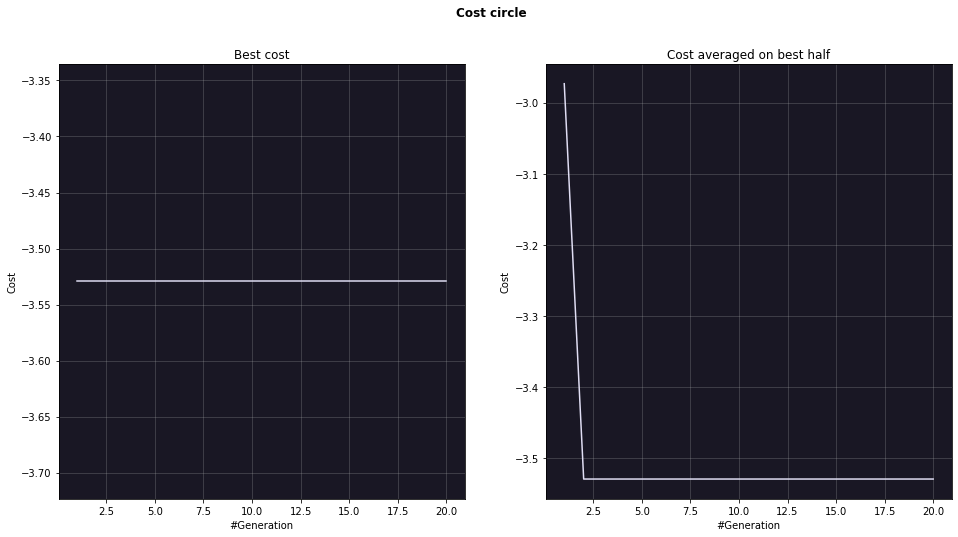

In [19]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('Cost circle', weight='bold')

data = np.genfromtxt("out/091-costs_square.csv", delimiter=",", skip_header=1)
x=np.arange(1,21)
#Best cost
y=data[:,0]

plt.subplot(121)
fig.axes[0].set_facecolor(stb)

plt.errorbar(x,y,color=ste)

plt.xlabel('#Generation')
plt.ylabel('Cost')
plt.title("Best cost")
plt.grid(alpha=0.3)

#Ave cost
y=data[:,1]

plt.subplot(122)
fig.axes[1].set_facecolor(stb)

plt.errorbar(x,y,color=ste)

plt.xlabel('#Generation')
plt.ylabel('Cost')
plt.title("Cost averaged on best half")
plt.grid(alpha=0.3)

plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

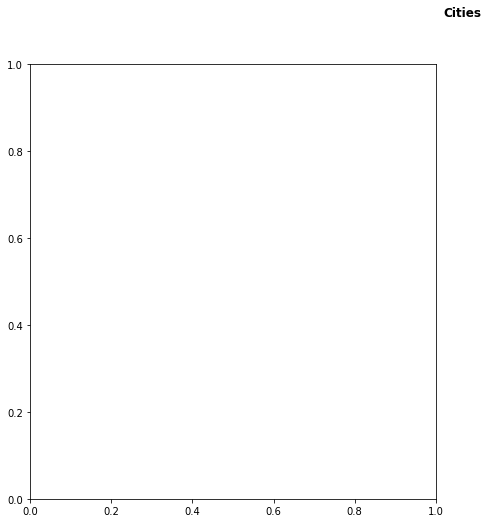

In [11]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('Cities', weight='bold')

plt.subplot(121)
data = np.genfromtxt("out/091-coord_circle.csv", delimiter=",", skip_header=0)
x=data[:,0]
y=data[:,1]
plt.scatter(x,y, label='test', color='k', s=25, marker="o")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Circle')


plt.subplot(122)
data = np.genfromtxt("out/091-coord_square.csv", delimiter=",", skip_header=0)
x=data[:,0]
y=data[:,1]
plt.scatter(x,y, label='test', color='k', s=25, marker="o")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Square')
plt.show()